In [36]:
import pandas as pd
import geopandas as geopd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import ipynb
%run helper.ipynb
%run all_sources_helper.ipynb
%run domain_helper.ipynb

In [37]:
dfbc = smr()
dfhs = health()
dfws = water_sources()
dfsp = stationary_sources()
dfes = emissions()
dffu = fuels()
dfms = marginalization()

C:\Users\Shobhit Jagga\AppData\Local\Temp\ipykernel_10576\4062585730.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dfws[chemical_columns] = dfws[chemical_columns].applymap(replace_concentration_values)


#### Merging all sources to get water source contamination, stationary source counts, emissions, health services, fuels, marginalization

In [38]:
df = pd.merge(dfbc, dfhs, on=['state_code','municipality_code','year'], how='left')
df = pd.merge(df, dfws, on=['state_code','municipality_code'], how='left')
df = pd.merge(df, dfsp, on=['state_code','municipality_code'], how='left')
df = pd.merge(df, dfes, on=['state_code','municipality_code','year'], how='left')
df = pd.merge(df, dffu, on=['state_code','municipality_code'], how='left')
df = pd.merge(df, dfms, on=['state_code','municipality_code'], how='left')
cancer_cols = ['support','social_assistance','outpatient_consultation','hospitalization','support_cumsum','social_assistance_cumsum','outpatient_consultation_cumsum','hospitalization_cumsum','risk_count','risk_concentration_sure','risk_concentration_possible','st_risk','concentration','electricity_fuel','firewood_fuel','oil_fuel','IMN_2020'] + st_activities
for col in cancer_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df[cancer_cols] = df[cancer_cols].fillna(0)

#### 1. Adding excess = observed - expected deaths
#### 2. Computing metrics for health care for our model
#### 3. Computing exponential average to account for previous years effects 

In [39]:
cola = ['state_code','municipality_code','year']
smrcols = ['age_group','location_type']
dfs = compute_smr(df, smrcols, cola, cancer_cols=cancer_cols,colname=1,mmode=1)
dfs['excess'] = dfs['smr']
dfs['support_metric'] = dfs['support_cumsum'] * dfs['ed']
dfs['social_assistance_metric'] = dfs['social_assistance_cumsum'] * dfs['ed']
dfs['outpatient_metric'] = dfs['outpatient_consultation_cumsum'] * dfs['ed']
dfs['hospitalization_metric'] = dfs['hospitalization_cumsum'] * dfs['ed']
dfs['health'] = dfs['support_metric'] + dfs['social_assistance_metric'] + dfs['outpatient_metric'] + dfs['hospitalization_metric']

In [40]:
# xcols = cancer_cols + ['support_metric','social_assistance_metric','outpatient_metric','hospitalization_metric','health']
# expcols = []
# for col in xcols:
#     exp_col_name = f"{col}_exp"
#     dfs[exp_col_name] = (
#         dfs.groupby(['state_code', 'municipality_code'])[col]
#         .apply(lambda x: x.ewm(alpha=0.05, adjust=False).mean())
#         .reset_index(drop=True)
#     )
#     expcols.append(exp_col_name)
# xcols = xcols + ['concentration_exp']

In [41]:
# vif = calculate_vif(dfs[cancer_cols])
# vif = vif.sort_values(by=['VIF'], ascending=[False])
# display(vif[ vif['VIF'] > 5 ])

In [42]:
import statsmodels.api as sm
fcol = [
    "support_cumsum", "social_assistance_cumsum", "outpatient_consultation_cumsum", "hospitalization_cumsum", 
    "risk_count", "risk_concentration_sure","risk_concentration_possible", 
    "concentration","IMN_2020", 
    "electricity_fuel", "firewood_fuel", "oil_fuel",
    "brick_factory", "st_risk",
]
# fcol = [
#     "support_count", "social_assistance_count", "outpatient_consultation_count", "hospitalization_count",
#     "carcinogenic_water_sources_count","water_sources_carcinogens_2B","water_sources_carcinogens_1",
#     "emission_concentration","marginalization", 
#     "electricity_fuel", "firewood_fuel", "oil_fuel",
#     "brick_factory", "stationary_risk_sources",
# ]
# X = dfs[fcol]
# y = dfs['excess']
dfs['next_excess'] = dfs.groupby(['state_code', 'municipality_code'])['excess'].shift(-1)
# dfs.rename(columns=final_col_mapping, inplace=True)
dff2 = dfs.dropna(subset=['next_excess'])
X = sm.add_constant(dff2[fcol])
model = sm.OLS(dff2['next_excess'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            next_excess   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     81.45
Date:                Mon, 30 Sep 2024   Prob (F-statistic):          5.24e-224
Time:                        01:08:11   Log-Likelihood:                -59367.
No. Observations:               12234   AIC:                         1.188e+05
Df Residuals:                   12219   BIC:                         1.189e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [43]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(dff2[fcol], dff2['next_excess'], test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(Xtrain)
X_test_scaled = scaler.transform(Xtest)
lasso = LassoCV(alphas=np.logspace(-10, 10, 100), cv=5, random_state=42, max_iter=100000)
lasso.fit(X_train_scaled, Ytrain)
print("Best alpha:", lasso.alpha_)
cv_scores = cross_val_score(lasso, X_train_scaled, Ytrain, cv=5)
print("Cross-validated training score:", np.mean(cv_scores))
test_score = lasso.score(X_test_scaled, Ytest)
print("Test score:", test_score)
coefficients = pd.Series(lasso.coef_, index=dff2[fcol].columns)
print("Coefficients:")
print(coefficients[coefficients != 0])
yPred = lasso.predict(Xtest)
yPredtrain = lasso.predict(Xtrain)
r2 = r2_score(Ytest, yPred)
r2 = r2_score(Ytrain, yPredtrain)
print("R² score:", r2)

Best alpha: 0.7924828983539186
Cross-validated training score: 0.035746503158264706
Test score: 0.09576833032527521
Coefficients:
outpatient_consultation_cumsum   -6.114178
risk_count                        0.006727
concentration                     0.150531
IMN_2020                          3.753326
electricity_fuel                 -1.095460
brick_factory                     3.156075
dtype: float64
R² score: -51385.877002047375


C:\Users\Shobhit Jagga\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(
C:\Users\Shobhit Jagga\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(


In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
%run helper.ipynb
# fcol = [
#     "support_cumsum", "social_assistance_cumsum", "outpatient_consultation_cumsum", "hospitalization_cumsum", 
#     "risk_count", "risk_concentration_sure","risk_concentration_possible", "st_risk", "concentration", 
#     "electricity_fuel", "firewood_fuel", "oil_fuel", "dumps", "biomass", "carpentry", "cement_gypsum", 
#     "sugarcane_cultivation", "chemical_manufacturing","pesticide_manufacturing", "gas_stations", "incinerator", 
#     "sugar_mill", "brick_factory", "mining", "paper_mill", "solvent_paint", "high_traffic_supply", 
#     "high_traffic_alameda","high_traffic_station", "support_cumsum_exp", "social_assistance_cumsum_exp", 
#     "outpatient_consultation_cumsum_exp", "hospitalization_cumsum_exp", "risk_count_exp", "risk_concentration_sure_exp", "risk_concentration_possible_exp", 
#     "st_risk_exp", "concentration_exp", "electricity_fuel_exp","firewood_fuel_exp", "oil_fuel_exp", "dumps_exp", 
#     "biomass_exp", "carpentry_exp", "cement_gypsum_exp", "sugarcane_cultivation_exp", "chemical_manufacturing_exp", 
#     "pesticide_manufacturing_exp", "gas_stations_exp", "incinerator_exp","sugar_mill_exp", "brick_factory_exp", 
#     "mining_exp","paper_mill_exp", "solvent_paint_exp", "high_traffic_supply_exp", "high_traffic_alameda_exp", 
#     "high_traffic_station_exp","IMN_2020"
# ]
# fcol = [
#     "support_cumsum", "social_assistance_cumsum", "outpatient_consultation_cumsum", "hospitalization_cumsum", 
#     "risk_count", "risk_concentration_sure","risk_concentration_possible", 
#     "concentration","IMN_2020", 
#     "electricity_fuel", "firewood_fuel", "oil_fuel",
#     "brick_factory", "st_risk",
# ]
fcol = [
    "support_count", "social_assistance_count", "outpatient_consultation_count", "hospitalization_count",
    "carcinogenic_water_sources_count","water_sources_carcinogens_2B","water_sources_carcinogens_1",
    "emission_concentration","marginalization", 
    "electricity_fuel", "firewood_fuel", "oil_fuel",
    "brick_factory", "stationary_risk_sources",
]
# dfs = dfs2
dfs['next_excess'] = dfs.groupby(['state_code', 'municipality_code'])['excess'].shift(-1)
dfs.rename(columns=final_col_mapping, inplace=True)
dff = dfs.dropna(subset=['next_excess'])
xtrain, xtest, ytrain, ytest = train_test_split(dff[fcol], dff['next_excess'], test_size=0.3, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(xtrain, ytrain)
ypred = rf_model.predict(xtest)
ypredtrain = rf_model.predict(xtrain)
rfr2 = r2_score(ytest, ypred)
rfr22 = r2_score(ytrain, ypredtrain)
rfmse2 = mean_squared_error(ytrain, ypredtrain)
rfmse = mean_squared_error(ytest, ypred)
print(rfr2)
print(rfr22)
print(rfmse)
print(rfmse2)

0.6184287264739821
0.9016644146002893
446.23790794339817
98.18769529731242


In [45]:
cross_val_scores = cross_val_score(rf_model, xtrain, ytrain, cv=5)
cross_val_mean = cross_val_scores.mean()
feature_importances = rf_model.feature_importances_
performance_stats = pd.DataFrame({
    'Metric': ['Train MSE', 'Test MSE', 'Train R^2', 'Test R^2', 'Cross-validated Score'],
    'Value': [rfmse2, rfmse, rfr22, rfr2, cross_val_mean]
})
print(performance_stats)

                  Metric       Value
0              Train MSE   98.187695
1               Test MSE  446.237908
2              Train R^2    0.901664
3               Test R^2    0.618429
4  Cross-validated Score    0.228494


In [46]:
importance_df = pd.DataFrame({
    'Feature': xtrain.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
display(importance_df)

,Feature,Importance
2,outpatient_consultation_count,0.222223
3,hospitalization_count,0.203309
8,marginalization,0.172080
7,emission_concentration,0.162662
1,social_assistance_count,0.100722
0,support_count,0.084495
12,brick_factory,0.023082
5,water_sources_carcinogens_2B,0.014287
13,stationary_risk_sources,0.012471
4,carcinogenic_water_sources_count,0.003123


In [47]:
import pickle
with open('../map_bc/static/model/random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

In [48]:
dfw = dfs[dfs['year']==2022]
dfw = dfs
dfw.loc[:, 'risk_prediction'] = rf_model.predict(dfw[fcol])
display(dfw)
output_file_path = '../map_bc/static/model/features.all.csv'
dfw[['state_code','municipality_code','risk_prediction','year']+fcol].to_csv(output_file_path, index=False)
with open(output_file_path, 'r+') as f:
    lines = f.readlines()
    if lines and lines[-1] == '\n':
        lines.pop() 
    f.seek(0)
    f.writelines(lines)
    f.truncate() 
output_file_path = '../map_bc/static/risks/riskprofile.all.csv'
dfw[['state_code','municipality_code','risk_prediction','year']].to_csv(output_file_path, index=False)
# with open(output_file_path, 'r+') as f:
#     lines = f.readlines()
#     if lines and lines[-1].strip() == '':
#         lines.pop()
#     f.seek(0)
#     f.writelines(lines)
#     f.truncate()
with open(output_file_path, 'r') as f:
    lines = [line for line in f if line.strip()]
with open(output_file_path, 'w') as f:
    f.writelines(lines)

,state_code,municipality_code,year,smr,support,social_assistance,outpatient_consultation,hospitalization,support_count,social_assistance_count,outpatient_consultation_count,hospitalization_count,carcinogenic_water_sources_count,water_sources_carcinogens_1,water_sources_carcinogens_2B,stationary_risk_sources,emission_concentration,electricity_fuel,firewood_fuel,oil_fuel,marginalization,dumps,biomass,carpentry,cement_gypsum,sugarcane_cultivation,chemical_manufacturing,pesticide_manufacturing,gas_stations,incinerator,sugar_mill,brick_factory,mining,paper_mill,solvent_paint,high_traffic_supply,high_traffic_alameda,high_traffic_station,ndeaths_y,ed,population,excess,support_metric,social_assistance_metric,outpatient_metric,hospitalization_metric,health,next_excess,risk_prediction
0,1,1,2009,-10.848033,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2510.117703,0.0,0.0,0.0,311.032115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,197,207848.032820,582006,-10.848033,2.078480e+05,0.000000e+00,0.000000e+00,0.000000e+00,2.078480e+05,-36.919256,16.052896
1,1,1,2010,-36.919256,6.0,0.0,3.0,0.0,7.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1998.706195,0.0,0.0,0.0,311.032115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140,176919.255859,456613,-36.919256,1.238435e+06,0.000000e+00,5.307578e+05,0.000000e+00,1.769193e+06,16.763249,13.809888
2,1,1,2011,16.763249,0.0,0.0,4.0,0.0,7.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,1997.866248,0.0,0.0,0.0,311.032115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,274,257236.751486,663927,16.763249,1.800657e+06,0.000000e+00,1.800657e+06,0.000000e+00,3.601315e+06,-3.896206,6.441503
3,1,1,2012,-3.896206,21.0,84.0,84.0,252.0,28.0,84.0,91.0,252.0,0.0,0.0,0.0,0.0,3795.866613,0.0,0.0,0.0,311.032115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,238,241896.206242,639522,-3.896206,6.773094e+06,2.031928e+07,2.201255e+07,6.095784e+07,1.100628e+08,25.910074,90.952097
4,1,1,2013,25.910074,0.0,0.0,25.0,0.0,28.0,84.0,116.0,252.0,0.0,0.0,0.0,0.0,3795.642997,0.0,0.0,0.0,311.032115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255,229089.925609,561789,25.910074,6.414518e+06,1.924355e+07,2.657443e+07,5.773066e+07,1.099632e+08,117.805546,91.321888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14322,32,57,2016,0.900583,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,8.0,0.000000,2.0,168.0,2.0,12.073149,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1099.416972,205,0.900583,0.000000e+00,0.000000e+00,1.099417e+03,1.099417e+03,2.198834e+03,NaN,1.237958
14323,32,58,2013,0.881034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,3.782354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,118.965764,38,0.881034,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.881034,0.845642
14324,32,58,2016,0.881034,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,3.782354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,118.965764,38,0.881034,0.000000e+00,0.000000e+00,1.189658e+02,0.000000e+00,1.189658e+02,0.882570,0.828050
14325,32,58,2020,0.882570,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,3.782354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,117.430307,58,0.882570,0.000000e+00,0.000000e+00,1.174303e+02,0.000000e+00,1.174303e+02,0.882570,0.828050


In [49]:
input_data = dfw[(dfw['state_code']==24) & (dfw['municipality_code']==35)][fcol]
display(input_data)
output = rf_model.predict(input_data)
print("Model Output:", output)

,support_count,social_assistance_count,outpatient_consultation_count,hospitalization_count,carcinogenic_water_sources_count,water_sources_carcinogens_2B,water_sources_carcinogens_1,emission_concentration,marginalization,electricity_fuel,firewood_fuel,oil_fuel,brick_factory,stationary_risk_sources
10436,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,115.309074,69.0,712.0,10.0,3.0,111.0
10437,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.000000,115.309074,69.0,712.0,10.0,3.0,111.0
10438,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.125520,115.309074,69.0,712.0,10.0,3.0,111.0
10439,0.0,0.0,51.0,0.0,0.0,0.0,0.0,0.051527,115.309074,69.0,712.0,10.0,3.0,111.0
10440,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.000000,115.309074,69.0,712.0,10.0,3.0,111.0
10441,0.0,0.0,52.0,1.0,0.0,0.0,0.0,0.000000,115.309074,69.0,712.0,10.0,3.0,111.0
10442,6.0,0.0,76.0,7.0,0.0,0.0,0.0,0.000000,115.309074,69.0,712.0,10.0,3.0,111.0
10443,18.0,0.0,208.0,7.0,0.0,0.0,0.0,0.000000,115.309074,69.0,712.0,10.0,3.0,111.0
10444,18.0,0.0,208.0,7.0,0.0,0.0,0.0,0.000000,115.309074,69.0,712.0,10.0,3.0,111.0
10445,18.0,0.0,210.0,9.0,0.0,0.0,0.0,0.000000,115.309074,69.0,712.0,10.0,3.0,111.0


Model Output: [ 1.03061064 -1.40734825 -0.70912922 -1.36188948  4.32125022  4.2309221
  5.52079428 -0.04487262 -0.04487262 20.12211057  7.71754835 11.94392847
 11.94392847]


In [50]:
import shap
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(input_data)

# Visualize SHAP values
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, input_data)

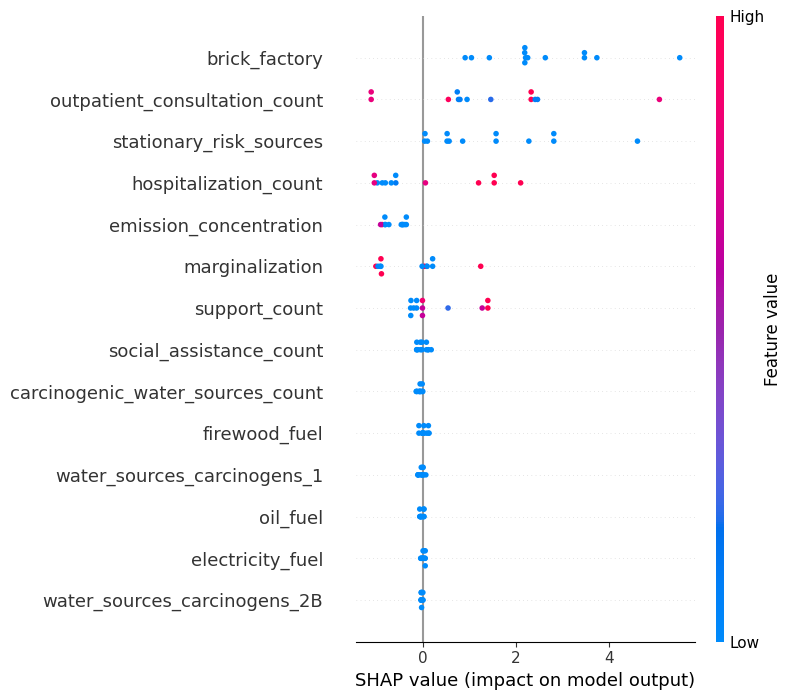

In [51]:
shap.summary_plot(shap_values, input_data)

In [52]:
# shap_values_df = pd.DataFrame(shap_values, columns=fcol)

# # Add a column for the expected value of the model's output
# expected_value = explainer.expected_value
# shap_values_df['Expected Value'] = expected_value

# # Calculate the contribution (predicted value)
# predicted_value = rf_model.predict(input_data)
# shap_values_df['Contribution'] = shap_values_df.sum(axis=1) + expected_value

# # Display the DataFrame
# display(shap_values_df)

In [53]:
# shap2 = explainer.shap_values(xtest)

In [54]:
interaction_values = explainer.shap_interaction_values(input_data)

In [55]:
# display(interaction_values.shape)
interaction_df = pd.DataFrame(interaction_values[0], columns=fcol)
interaction_sum = interaction_df.sum()
display(interaction_sum)
# feature1 = 'brick_factory'
# feature2 = 'st_risk'
# shap.dependence_plot(feature1, shap_values, input_data, interaction_index=feature2)
# shap.force_plot(explainer.expected_value, shap_values[0], input_data.iloc[0])

support_count                      -0.197603
social_assistance_count            -0.107497
outpatient_consultation_count       0.949803
hospitalization_count              -0.678238
carcinogenic_water_sources_count   -0.090871
water_sources_carcinogens_2B       -0.033332
water_sources_carcinogens_1        -0.107330
emission_concentration             -0.730240
marginalization                    -1.009923
electricity_fuel                   -0.046717
firewood_fuel                      -0.007456
oil_fuel                           -0.031517
brick_factory                       2.254178
stationary_risk_sources             0.565171
dtype: float64